In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
from torchinfo import summary
from PIL import Image
import re
from tqdm import tqdm
import pandas as pd
import seaborn as sns

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data
---------

Download the data [here](link) and extract it to the directory `'data/processed/stylized_tiny_imagenet'`.



In [3]:
#path to the extracted data
import glob
data_dir = 'data/processed/stylized_tiny_imagenet'

from src.data.Human16ToTinyImage import ClassConverter
classconv = ClassConverter()
#print(classconv.human16_to_imgnet_id['knife'])

mapping_207 = dict()
mapping_207_reverse = list(classconv.imgnet_id_to_human16.keys())
for idx, key in enumerate(mapping_207_reverse):
    mapping_207[key]=idx

# print(mapping_207)
# print(len(mapping_207_reverse))

In [4]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def get_class_label(self, image_name):
        # your method here
        image_name_split = re.split(r"-|_", image_name)
        #print(image_name_split)
        y = list()
        #original class then texture class
        y.append(mapping_207[image_name_split[1]])
        y.append(mapping_207[image_name_split[4]])
        return y
    def get_class_label_train(self, image_name):
        # your method here
        image_name_split = re.split(r"-|_|\\", image_name)
        #print(image_name_split)
        y = list()
        #original class then texture class
        y.append(mapping_207[image_name_split[2]])
        y.append(mapping_207[image_name_split[5]])
        return y
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        #print(image_path)
        #print(image_path.split('/')[-1])
        x = Image.open(image_path)
        if 'train' in image_path:
            y = self.get_class_label_train(image_path.split('/')[-1])
        else:
            y = self.get_class_label(image_path.split('/')[-1])
        if self.transform is not None:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms_224 = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def dataload(batch_size,data_transforms=data_transforms):

    image_datasets = {x: MyDataset(glob.glob(f"{data_dir}/{x}/*"), data_transforms[x])
                      for x in ['test', 'val']}

    image_datasets['train'] = MyDataset(glob.glob(f"{data_dir}/train/*/*"), data_transforms['train'])

    # image_datasets_train = datasets.ImageFolder(os.path.join(data_dir, 'train'),
    #                                           data_transforms['train'])
    #num_workers = 0 otherwise dataloader won't process
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=0)
                  for x in ['test','train','val']}

    # dataloaders_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=4,
    #                                               shuffle=True, num_workers=4)

    dataset_sizes = {x: len(image_datasets[x]) for x in ['test','train','val']}

    return image_datasets,dataloaders,dataset_sizes

batch_size_default = 64
image_datasets,dataloaders,dataset_sizes= dataload(batch_size=batch_size_default)

#class_names = image_datasets_train.classes
class_size = len(mapping_207_reverse)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
print(dataset_sizes)
print(image_datasets)

{'test': 10350, 'train': 103500, 'val': 10350}
{'test': <__main__.MyDataset object at 0x00000203DE263280>, 'val': <__main__.MyDataset object at 0x00000203DE263340>, 'train': <__main__.MyDataset object at 0x00000203DE263250>}


In [7]:
print(image_datasets['train'][0][1])

[49, 35]


In [8]:
# class_all = image_datasets.classes
# for i, imclass in enumerate(class_all):
#     #print(imclass)
#     class_all[i]=classconv.imgnet_id_to_human16[imclass]
# class_16 = list(set(class_all))
class_16_listed = ['knife', 'keyboard', 'elephant', 'bicycle', 'airplane', 
'clock', 'oven','chair', 'bear', 'boat','cat','bottle','truck','car','bird','dog']
# print(class_16)
print(len(class_16_listed))

16


In [36]:
mapping_207_reverse[200]

'n02112350'

In [39]:
#get the category of the label
print(image_datasets['train'][0][1][0])

#convert 207ids to 16 class
num = mapping_207_reverse[200]

def map207_to_16(num):
    return class_16_listed.index(classconv.imgnet_id_to_human16[num])
def map207_to_16names(num):
    return classconv.imgnet_id_to_human16[num]
    
print(map207_to_16(num))
print(map207_to_16names(num))

49
15
dog


## class balance and visualizations

In [14]:
class_count_shape = [0]*class_size
class_count_texture = [0]*class_size

In [11]:
#calculate class balance for 207 classes
#long runtime 8 min
for i in range(len(image_datasets['train'])):
    class_count_shape[image_datasets['train'][i][1][0]] += 1
    class_count_texture[image_datasets['train'][i][1][1]] += 1
print(class_count_shape)
print(class_count_texture)

KeyboardInterrupt: 

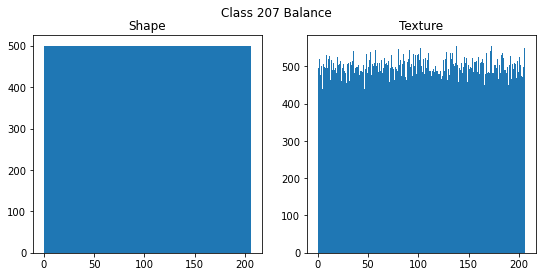

In [111]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(9, 4))

ax0.set_title('Shape')
ax0.hist(np.arange(class_size),bins=class_size,weights=class_count_shape)

ax1.set_title('Texture')
ax1.hist(np.arange(class_size),bins=class_size,weights=class_count_texture)

fig.suptitle('Class 207 Balance')
plt.show()

In [106]:
class_count16_shape = [0]*16
class_count16_texture = [0]*16

#calculate class balance for 16 classes
for i in range(class_size):
    class_count16_shape[map207_to_16(i)] += class_count_shape[i]
    class_count16_texture[map207_to_16(i)] += class_count_shape[i]

print(class_count16_shape)
print(class_count16_texture)

[500, 1000, 1000, 1000, 500, 1500, 500, 2000, 2000, 2500, 3000, 3500, 4000, 1500, 24500, 54500]
[500, 1000, 1000, 1000, 500, 1500, 500, 2000, 2000, 2500, 3000, 3500, 4000, 1500, 24500, 54500]


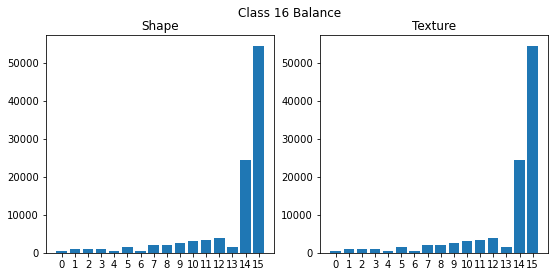

['knife', 'keyboard', 'elephant', 'bicycle', 'airplane', 'clock', 'oven', 'chair', 'bear', 'boat', 'cat', 'bottle', 'truck', 'car', 'bird', 'dog']


In [132]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=(9, 4))

ax0.set_title('Shape')
ax0.bar(np.arange(len(class_16_listed)),class_count16_shape)
# ax0.hist(np.arange(0.5,len(class_16_listed)+0.5,1),bins=len(class_16_listed),weights=class_count16_shape,width=1)
ax0.set_xticks(np.arange(len(class_16_listed)),
                  labels=np.arange(len(class_16_listed)))

ax1.set_title('Texture')
# ax1.hist(np.arange(0.5,len(class_16_listed)+0.5,1),bins=len(class_16_listed),weights=class_count16_texture,width=1)
# ax1.set_xticks(np.arange(len(class_16_listed)),
#                   labels=np.arange(len(class_16_listed)))
ax1.bar(np.arange(len(class_16_listed)),class_count16_texture)
fig.suptitle('Class 16 Balance')
plt.show()
print(class_16_listed)

In [133]:
# Class 207 weight
class_weights_207 = 1./torch.tensor(class_count_shape, dtype=torch.float) 
print(class_weights_207)

# Class 16 weight
class_weights_16 = 1./torch.tensor(class_count16_shape, dtype=torch.float) 
print(class_weights_16)

tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 

In [146]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

In [147]:
print(classes)

[tensor([49, 49, 49, 49]), tensor([164, 138, 113,   0])]


In [43]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [143]:
print(classes[0])
print(list(zip(*classes)))

tensor([49, 49, 49, 49])
[(tensor(49), tensor(35)), (tensor(49), tensor(24)), (tensor(49), tensor(89)), (tensor(49), tensor(3))]


# Training the model (Helper functions)



In [81]:
def train_model(model, criterion, optimizer, scheduler, dataloaders,dataset_sizes,device, num_epochs=25):
    #early stopping
    the_last_loss = 100
    patience = 5
    trigger_times = 0

    #acc and loss list
    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            #print(phase)
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels[0].to(device)
                #print(inputs)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(preds)
                    loss = criterion(outputs, labels)
                    #print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                loss_stats['train'].append(epoch_loss)
                accuracy_stats['train'].append(epoch_acc)
            else:
                the_current_loss = epoch_loss
                loss_stats['val'].append(epoch_loss)
                accuracy_stats['val'].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        #early stopping
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model,loss_stats,accuracy_stats
        else:
            print('Trigger times: 0')
            trigger_times = 0
        the_last_loss = the_current_loss


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_stats,accuracy_stats

Save load model

In [46]:
def model_save_load(model,name='model.pth',save=True,path='/models/trained_models'):
      if save == True:
            torch.save(copy.deepcopy(model.state_dict()), os.path.join(path, name))
      else:
            model.load_state_dict(torch.load(os.path.join(path, name)))
            return model

#os.path.join(path, name)

Visualizing loss acc trend

In [24]:
def visualize_loss_acc(loss_stats, accuracy_stats):
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

(not yet tested/completed) Evaluation/confusion matrix report etc.

In [25]:
# from sklearn.metrics import confusion_matrix, classification_report
# confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

# sns.heatmap(confusion_matrix_df, annot=True)
# print(classification_report(y_test, y_pred_list))

Visualizing/test the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [83]:
def visualize_model(model, dataloaders, test = True, class_map = mapping_207_reverse, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    if test == True:
        select = 'test'
    else:
        select = 'val'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[select]):
            if i == 0 : 
                print(type(inputs))
            inputs = inputs.to(device)
            shapes = labels[0].to(device)
            textures = labels[1].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

                pred_nameid = class_map[preds[j]]
                pred_name = map207_to_16names(pred_nameid)
                
                lab_nameid = class_map[shapes[j]]
                lab_name = map207_to_16names(lab_nameid)
                
                tex_nameid = class_map[textures[j]]
                tex_name = map207_to_16names(tex_nameid)

                nl = '\n'

                ax.set_title(f'Predicted: {pred_name}, ID: {pred_nameid} {nl} True: {lab_name}, ID: {lab_nameid} {nl} Texture: {tex_name}, ID: {tex_nameid}')


                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [76]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data

# #batch size need to be set to 4
# inputs, classes = next(iter(dataloaders['train']))

# print(list(zip(*classes)))
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=None)

In [43]:
#free up cuda memory
def freemem():
    with torch.no_grad():
        torch.cuda.empty_cache()

# Finetuning/training the models
----------------------
Defaults
- batch size: 256
- momentum: 0.9
- weight decay: 1e-4
- lr: 0.1 multiplied by 0.1 after every 20 epochs
- pretrained: `torchvision.models.resnet50(pretrained=True)`
- epochs: 60


Note `nn.Sequential(nn.AdaptiveAvgPool2d((224,224)),net)` is added for models that take in 224x224 images


In [44]:
#Defaults
def model_default_train(model,dataloaders,dataset_sizes,device,epoch = 60):
    model.to(device=device)
    criterion = nn.CrossEntropyLoss().to(device=device)
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    # Decay LR by a factor of 0.1 every 20 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

    return train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders,dataset_sizes,device,
                       num_epochs=epoch)


### CoAtNet

In [18]:
from src.models.coatnet import coatnet_0
cnet = coatnet_0()
cnet.fc = nn.Linear(in_features=cnet.fc.in_features, out_features=class_size, bias=True)
cnet = nn.Sequential(nn.AdaptiveAvgPool2d((224,224)),cnet)
#print(cnet)


C:\Users\ccarc\Anaconda3\envs\ift6759\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
#test save/load model
windows_path = 'C:/Users/ccarc/Desktop/IFT 6759/Project/convolution-vs-attention/models/trained_models'
model_save_load(model=cnet,path=windows_path)
cnet = model_save_load(save=False,model=cnet,path=windows_path)

In [ ]:
summary(cnet, input_size=(batch_size_default, 3, 224, 224))

In [19]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=32)
freemem()
cnet,cnet_ls,cnet_as = model_default_train(cnet,dataloaders,dataset_sizes,device,epoch = 1)

Epoch 0/0
----------


  1%|▏         | 44/3235 [00:21<25:25,  2.09it/s] 


KeyboardInterrupt: 

<class 'torch.Tensor'>


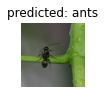

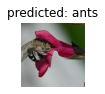

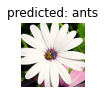

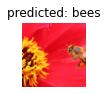

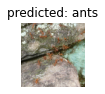

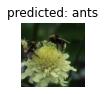

In [102]:
visualize_model(cnet,dataloaders)

### ConvNeXt

In [32]:
convnext = models.convnext_small(pretrained=False)
convnext.classifier[2] = nn.Linear(in_features=convnext.classifier[2].in_features, out_features=class_size, bias=True)
convnext = nn.Sequential(nn.AdaptiveAvgPool2d((224,224)),convnext)
#print(convnext)

In [15]:
summary(convnext, input_size=(batch_size_default, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ConvNeXt                                      --                        --
├─Sequential: 1-1                             [16, 768, 7, 7]           --
│    └─ConvNormActivation: 2-1                [16, 96, 56, 56]          --
│    │    └─Conv2d: 3-1                       [16, 96, 56, 56]          4,704
│    │    └─LayerNorm2d: 3-2                  [16, 96, 56, 56]          192
│    └─Sequential: 2-2                        [16, 96, 56, 56]          --
│    │    └─CNBlock: 3-3                      [16, 96, 56, 56]          79,296
│    │    └─CNBlock: 3-4                      [16, 96, 56, 56]          79,296
│    │    └─CNBlock: 3-5                      [16, 96, 56, 56]          79,296
│    └─Sequential: 2-3                        [16, 192, 28, 28]         --
│    │    └─LayerNorm2d: 3-6                  [16, 96, 56, 56]          192
│    │    └─Conv2d: 3-7                       [16, 192, 28, 28]         73,920

In [ ]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=batch_size_default)
freemem()
convnext,convnext_ls,convnext_as = model_default_train(convnext,dataloaders,dataset_sizes,device,epoch = 60)

In [ ]:
visualize_model(convnext,dataloaders)

### ViTb32

In [47]:
vitb32 = models.vit_b_32(pretrained=False)
vitb32.heads.head = nn.Linear(in_features=vitb32.heads.head.in_features, out_features=class_size, bias=True)
vitb32 = nn.Sequential(nn.AdaptiveAvgPool2d((224,224)),vitb32)
#print(vitb32)

In [62]:
summary(vitb32, input_size=(batch_size_default, 3, 224, 224))

Layer (type:depth-idx)                                            Output Shape              Param #
VisionTransformer                                                 --                        --
├─Conv2d: 1-1                                                     [4, 768, 7, 7]            2,360,064
├─Encoder: 1-2                                                    [4, 50, 768]              --
│    └─Dropout: 2-1                                               [4, 50, 768]              --
│    └─Sequential: 2-2                                            [4, 50, 768]              --
│    │    └─EncoderBlock: 3-1                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-2                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-3                                     [4, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-4                                     [4, 50, 768]              7,087,872
│    │    

In [ ]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=batch_size_default)
freemem()
vitb32,vitb32_ls,vitb32_as = model_default_train(vitb32,dataloaders,dataset_sizes,device,epoch = 60)

In [ ]:
visualize_model(vitb32,dataloaders)

### Resnet 50 with resized inputs

In [18]:
res50_224 = models.resnet50(pretrained=True)
num_ftrs = res50_224.fc.in_features
# Here the size of each output sample is set to class_size
res50_224.fc = nn.Linear(num_ftrs, class_size)
#print(res50_224)

In [19]:
#load data and train
_,dataloaders,dataset_sizes= dataload(32,data_transforms_224)
freemem()
res50_224,res50_224_ls,res50_224_as = model_default_train(res50_224,dataloaders,dataset_sizes,device,epoch = 10)

Epoch 0/9
----------


  1%|          | 23/3235 [00:12<28:25,  1.88it/s] 


KeyboardInterrupt: 

In [ ]:
visualize_model(res50_224,dataloaders)

### Resnet 50 with adaptive pooling

In [38]:
res50 = models.resnet50(pretrained=True)
num_ftrs = res50.fc.in_features
#adapt to 224x224 resolution
res50 = nn.Sequential(nn.AdaptiveAvgPool2d((224,224)),res50)
# Here the size of each output sample is set to class_size
res50[1].fc = nn.Linear(num_ftrs, class_size)
#print(res50)

In [39]:
summary(res50, input_size=(batch_size_default, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    --                        --
├─AdaptiveAvgPool2d: 1-1                      [64, 3, 224, 224]         --
├─ResNet: 1-2                                 [64, 207]                 --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [64, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [64, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [64, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [64, 512, 28, 28]         --
│   

In [40]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=64)
freemem()
res50,res50_ls,res50_as = model_default_train(res50,dataloaders,dataset_sizes,device,epoch = 60)

Epoch 0/59
----------


  1%|          | 15/1618 [00:10<19:16,  1.39it/s]


KeyboardInterrupt: 

In [ ]:
visualize_model(res50,dataloaders)

### Resnet 50 w/o adaptive pooling

In [47]:
res50_64 = models.resnet50(pretrained=True)
num_ftrs = res50_64.fc.in_features
# Here the size of each output sample is set to class_size
res50_64.fc = nn.Linear(num_ftrs, class_size)
#print(res50_64)

In [ ]:
summary(res50_64, input_size=(batch_size_default, 3, 224, 224))

In [48]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=64)
freemem()
res50_64,res50_64_ls,res50_64_as = model_default_train(res50_64,dataloaders,dataset_sizes,device,epoch = 60)

Epoch 0/59
----------


100%|██████████| 1618/1618 [03:37<00:00,  7.45it/s]


train Loss: 5.3605 Acc: 0.0046


100%|██████████| 162/162 [00:12<00:00, 12.91it/s]


val Loss: 5.3369 Acc: 0.0050

Trigger times: 0
Epoch 1/59
----------


100%|██████████| 1618/1618 [03:07<00:00,  8.62it/s]


train Loss: 5.3274 Acc: 0.0056


100%|██████████| 162/162 [00:10<00:00, 16.16it/s]


val Loss: 5.3849 Acc: 0.0068

Trigger times: 1
Epoch 2/59
----------


100%|██████████| 1618/1618 [03:15<00:00,  8.29it/s]


train Loss: 5.2778 Acc: 0.0088


100%|██████████| 162/162 [00:10<00:00, 15.45it/s]


val Loss: 5.2704 Acc: 0.0094

Trigger times: 0
Epoch 3/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.72it/s]


train Loss: 5.2436 Acc: 0.0111


100%|██████████| 162/162 [00:09<00:00, 16.88it/s]


val Loss: 5.2807 Acc: 0.0109

Trigger times: 1
Epoch 4/59
----------


100%|██████████| 1618/1618 [02:55<00:00,  9.21it/s]


train Loss: 5.2013 Acc: 0.0143


100%|██████████| 162/162 [00:09<00:00, 16.92it/s]


val Loss: 5.2240 Acc: 0.0142

Trigger times: 0
Epoch 5/59
----------


100%|██████████| 1618/1618 [02:57<00:00,  9.10it/s]


train Loss: 5.1566 Acc: 0.0174


100%|██████████| 162/162 [00:15<00:00, 10.65it/s]


val Loss: 5.1764 Acc: 0.0173

Trigger times: 0
Epoch 6/59
----------


100%|██████████| 1618/1618 [03:32<00:00,  7.60it/s]


train Loss: 5.1221 Acc: 0.0214


100%|██████████| 162/162 [00:10<00:00, 15.95it/s]


val Loss: 5.1664 Acc: 0.0198

Trigger times: 0
Epoch 7/59
----------


100%|██████████| 1618/1618 [03:13<00:00,  8.35it/s]


train Loss: 5.0927 Acc: 0.0239


100%|██████████| 162/162 [00:11<00:00, 14.17it/s]


val Loss: 5.1254 Acc: 0.0236

Trigger times: 0
Epoch 8/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.72it/s]


train Loss: 5.0632 Acc: 0.0260


100%|██████████| 162/162 [00:10<00:00, 15.33it/s]


val Loss: 5.1689 Acc: 0.0214

Trigger times: 1
Epoch 9/59
----------


100%|██████████| 1618/1618 [03:14<00:00,  8.33it/s]


train Loss: 5.0249 Acc: 0.0301


100%|██████████| 162/162 [00:10<00:00, 16.08it/s]


val Loss: 5.0652 Acc: 0.0291

Trigger times: 0
Epoch 10/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.73it/s]


train Loss: 4.9930 Acc: 0.0328


100%|██████████| 162/162 [00:09<00:00, 17.04it/s]


val Loss: 5.0409 Acc: 0.0316

Trigger times: 0
Epoch 11/59
----------


100%|██████████| 1618/1618 [03:04<00:00,  8.79it/s]


train Loss: 4.9608 Acc: 0.0358


100%|██████████| 162/162 [00:09<00:00, 16.72it/s]


val Loss: 5.0267 Acc: 0.0339

Trigger times: 0
Epoch 12/59
----------


100%|██████████| 1618/1618 [03:09<00:00,  8.55it/s]


train Loss: 4.9273 Acc: 0.0399


100%|██████████| 162/162 [00:08<00:00, 18.02it/s]


val Loss: 5.0376 Acc: 0.0314

Trigger times: 1
Epoch 13/59
----------


100%|██████████| 1618/1618 [02:51<00:00,  9.41it/s]


train Loss: 4.8927 Acc: 0.0435


100%|██████████| 162/162 [00:09<00:00, 17.42it/s]


val Loss: 4.9909 Acc: 0.0377

Trigger times: 0
Epoch 14/59
----------


100%|██████████| 1618/1618 [02:50<00:00,  9.47it/s]


train Loss: 4.8571 Acc: 0.0472


100%|██████████| 162/162 [00:09<00:00, 17.09it/s]


val Loss: 4.9680 Acc: 0.0386

Trigger times: 0
Epoch 15/59
----------


100%|██████████| 1618/1618 [02:59<00:00,  9.01it/s]


train Loss: 4.8196 Acc: 0.0508


100%|██████████| 162/162 [00:09<00:00, 16.51it/s]


val Loss: 5.0086 Acc: 0.0357

Trigger times: 1
Epoch 16/59
----------


100%|██████████| 1618/1618 [03:09<00:00,  8.53it/s]


train Loss: 4.7822 Acc: 0.0548


100%|██████████| 162/162 [00:10<00:00, 16.08it/s]


val Loss: 4.9722 Acc: 0.0443

Trigger times: 0
Epoch 17/59
----------


100%|██████████| 1618/1618 [03:09<00:00,  8.55it/s]


train Loss: 4.7439 Acc: 0.0595


100%|██████████| 162/162 [00:10<00:00, 16.16it/s]


val Loss: 5.0108 Acc: 0.0373

Trigger times: 1
Epoch 18/59
----------


100%|██████████| 1618/1618 [03:08<00:00,  8.58it/s]


train Loss: 4.7057 Acc: 0.0629


100%|██████████| 162/162 [00:10<00:00, 15.41it/s]


val Loss: 4.9800 Acc: 0.0419

Trigger times: 0
Epoch 19/59
----------


100%|██████████| 1618/1618 [03:09<00:00,  8.56it/s]


train Loss: 4.6613 Acc: 0.0670


100%|██████████| 162/162 [00:11<00:00, 14.31it/s]


val Loss: 4.9727 Acc: 0.0420

Trigger times: 0
Epoch 20/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.72it/s]


train Loss: 4.3055 Acc: 0.1124


100%|██████████| 162/162 [00:10<00:00, 15.34it/s]


val Loss: 4.9048 Acc: 0.0528

Trigger times: 0
Epoch 21/59
----------


100%|██████████| 1618/1618 [03:06<00:00,  8.69it/s]


train Loss: 4.1426 Acc: 0.1343


100%|██████████| 162/162 [00:10<00:00, 15.55it/s]


val Loss: 4.9376 Acc: 0.0527

Trigger times: 1
Epoch 22/59
----------


100%|██████████| 1618/1618 [03:06<00:00,  8.69it/s]


train Loss: 4.0257 Acc: 0.1502


100%|██████████| 162/162 [00:09<00:00, 16.58it/s]


val Loss: 4.9844 Acc: 0.0521

Trigger times: 2
Epoch 23/59
----------


100%|██████████| 1618/1618 [03:07<00:00,  8.64it/s]


train Loss: 3.9058 Acc: 0.1682


100%|██████████| 162/162 [00:09<00:00, 16.57it/s]


val Loss: 5.0434 Acc: 0.0496

Trigger times: 3
Epoch 24/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.74it/s]


train Loss: 3.7819 Acc: 0.1854


100%|██████████| 162/162 [00:09<00:00, 16.21it/s]


val Loss: 5.1023 Acc: 0.0476

Trigger times: 4
Epoch 25/59
----------


100%|██████████| 1618/1618 [03:05<00:00,  8.73it/s]


train Loss: 3.6394 Acc: 0.2108


100%|██████████| 162/162 [00:10<00:00, 15.31it/s]

val Loss: 5.2001 Acc: 0.0455

Trigger times: 5
Early stopping!
Start to test process.
Training complete in 85m 50s
Best val Acc: 0.052754


In [49]:
#test save/load model
windows_path = 'C:/Users/ccarc/Desktop/IFT 6759/Project/convolution-vs-attention/models/trained_models'
model_save_load(name='res50_64.pth',model=res50_64,path=windows_path)
res50_64 = model_save_load(name='res50_64.pth',save=False,model=res50_64,path=windows_path)

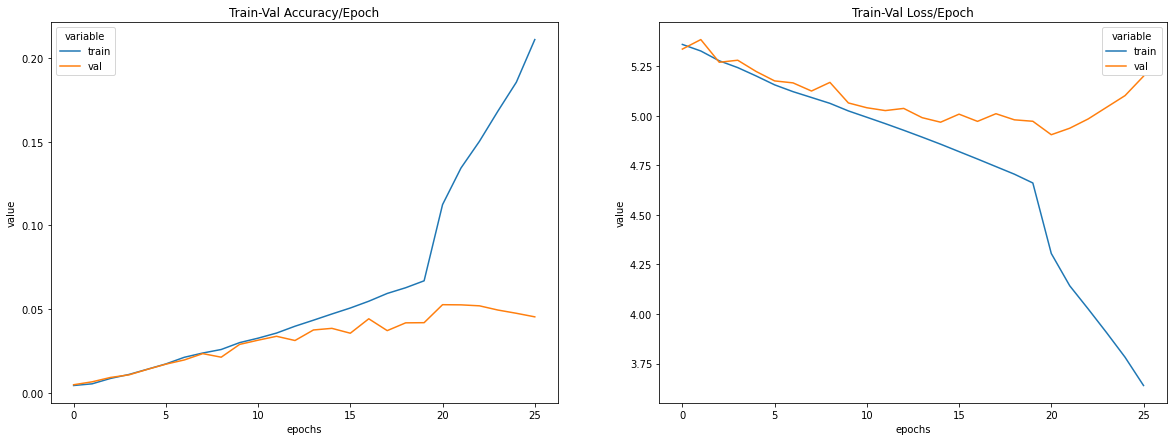

In [70]:
visualize_loss_acc(res50_64_ls,res50_64_as)

<class 'torch.Tensor'>


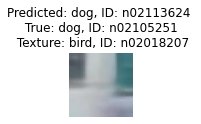

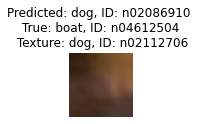

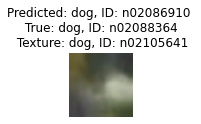

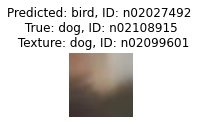

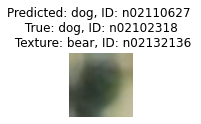

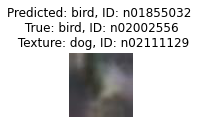

In [84]:
visualize_model(res50_64,dataloaders)

### ConvNet as fixed feature extractor (to be tested)
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [47]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, class_size)


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
#load data and train
_,dataloaders,dataset_sizes= dataload(batch_size=32)
freemem()
model_conv,model_conv_ls,model_conv_as = model_default_train(model_conv,dataloaders,dataset_sizes,device,epoch = 60)


In [ ]:
visualize_model(model_conv,dataloaders)


Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





## HuggingFace Tutorial

[Installation](https://huggingface.co/docs/transformers/installation).
Only version 4.17.0 has ConvNext Model
`pip install transformers==4.17.0`
`conda install -c huggingface transformers==4.17.0`
`conda install -c conda-forge transformers==4.17.0`

### Sentiment analysis Test
`python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"`

### ConvNext

In [1]:
from transformers import ConvNextModel, ConvNextConfig

# Initializing a ConvNext convnext-tiny-224 style configuration
configuration = ConvNextConfig()
# Initializing a model from the convnext-tiny-224 style configuration
model = ConvNextModel(configuration)
# Accessing the model configuration
configuration = model.config

In [ ]:
from transformers import ConvNextFeatureExtractor, ConvNextModel
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")
model = ConvNextModel.from_pretrained("facebook/convnext-tiny-224")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

ConvNext from source

`git clone https://github.com/facebookresearch/ConvNeXt`
`pip install timm==0.3.2 tensorboardX six`

### CLIP Feature extractor with a single linear head

In [ ]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

In [204]:
#on test data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

#location of the extracted data
data_dir = 'data/hymenoptera_data'
image_datasets_clip = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#loads the PIL image into tensor
dataloaders_clip = {x: torch.utils.data.DataLoader(image_datasets_clip[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [173]:
#see an example image of an ant
import random

print(random.sample(range(len(image_datasets_clip['val'])), 10))


[43, 151, 116, 138, 47, 121, 131, 135, 101, 139]


In [187]:
for i ,x in dataloaders_clip['val']:
    print(i.shape)
    break


torch.Size([1, 3, 224, 224])


In [239]:
def visualize_model_clip(model,processor,class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (image, label) in enumerate(dataloaders_clip['val']):
            #change image datatype to correct jpg
            #print(image.size)
            inputs = processor(
                text=class_names, images=image[0], return_tensors="pt", padding=True
            )
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
            _, preds = torch.max(probs, 1)
            
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds]))
            print('True: {}'.format(class_names[label]))
            plt.imshow(transforms.ToPILImage()(image[0]))
            plt.pause(0.001)  # pause a bit so that plots are updated
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)

True: bees


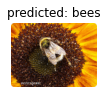

True: ants


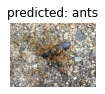

True: bees


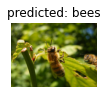

True: ants


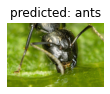

True: bees


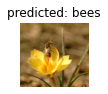

True: ants


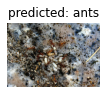

In [240]:
visualize_model_clip(model,processor,class_16_listed)

In [209]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
#image = image_datasets_clip['val'][100][0]
for i ,x in dataloaders_clip['val']:
    inputs = processor(
        text=["ants", "bees"], images=i, return_tensors="pt", padding=True
    )
    break


outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [225]:
transforms.ToPILImage()(i[0]).show()

In [208]:
print(probs)

tensor([[0.0062, 0.9938]], grad_fn=<SoftmaxBackward0>)


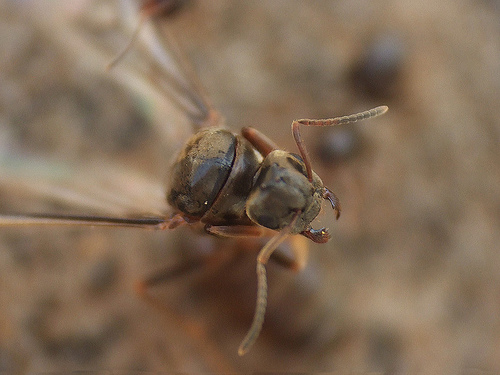

In [148]:
image

In [97]:
print(inputs)

{'input_ids': tensor([[49406,  2368, 49407],
        [49406,  1929, 49407]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]]), 'pixel_values': tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1

In [75]:
print(image)
image.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x26FA090D6D0>


In [217]:
_, pred = torch.max(probs, 1)
print(pred)

tensor([0])


In [220]:
ll = [9, 4]
print(ll[pred])

9


# Computing shape bias of a model

1. Evaluate your models on all 1,280 images here (https://github.com/rgeirhos/texture-vs-shape/tree/master/stimuli/style-transfer-preprocessed-512).
2. Map model decisions to 16 classes using the code provided above [dataload](#load-data)
3. Exclude images without a cue conflict (e.g. texture=cat, shape=cat).
4. Take the subset of "correctly" classified images (either shape or texture category correctly predicted).
5. Compute "shape bias" as the following fraction: (correct shape decisions) / (correct shape decisions + correct texture decisions).